In [10]:
import numpy as np
import pandas as pd
import os
import string
import re
import warnings 
warnings.filterwarnings('ignore')

#plotting libraries!
import matplotlib.pyplot as plt
import seaborn as sns
!pip install shapely
from shapely.geometry import Point
!pip install geopandas
import geopandas as gpd
from geopandas import GeoDataFrame
%matplotlib inline
#PLOTLY
import plotly
import plotly.offline as offline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
from collections import defaultdict
from plotly import tools
from plotly.graph_objs import Scatter, Figure, Layout
cf.set_config_file(offline=True)
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
!pip install pyldavis 
import pyLDAvis
#import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
!pip install squarify
import squarify
from PIL import Image
from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
!pip install textblob
from textblob import TextBlob
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()

  Obtaining dependency information for textblob from https://files.pythonhosted.org/packages/02/07/5fd2945356dd839974d3a25de8a142dc37293c21315729a41e775b5f3569/textblob-0.18.0.post0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 5.3 MB/s eta 0:00:0000:0100:01


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/krishnapeddibhotla/nltk_data...
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/krishnapeddibhotla/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krishnapeddibhotla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/krishnapeddibhotla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/krishnapeddibhotla/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [11]:
!pip install tweet-preprocessor
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.EMOJI)

  Obtaining dependency information for tweet-preprocessor from https://files.pythonhosted.org/packages/17/9d/71bd016a9edcef8860c607e531f30bd09b13103c7951ae73dd2bf174163c/tweet_preprocessor-0.6.0-py3-none-any.whl.metadata


In [16]:
df = pd.read_csv('/Users/krishnapeddibhotla/Downloads/US Election using twitter sentiment/Bidenall2.csv')

In [17]:
df.head(5)

,user,text
0,MarkHodder3,@JoeBiden And we’ll find out who won in 2026...
1,K87327961G,@JoeBiden Your Democratic Nazi Party cannot be...
2,OldlaceA,@JoeBiden So did Lying Barr
3,penblogger,@JoeBiden It's clear you didnt compose this tw...
4,Aquarian0264,@JoeBiden I will vote in person thank you.


In [18]:
# Checking for NAN values
df.isna().sum()

# Changing the timestamp to datetime format
#data['timestamp']=pd.to_datetime(data['timestamp'])
#data.head()

user    0
text    0
dtype: int64

In [19]:
print(df['text'][2])
Tweet = TextBlob(df['text'][4])
Tweet.sentiment

@JoeBiden So did Lying Barr


Sentiment(polarity=0.0, subjectivity=0.0)

In [20]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
cleantweets = []
postags = []
import string
table = str.maketrans('','', string.punctuation)
for title in df['text']:
    try:
        title = p.clean(text)
        #tokenize + lower case
        words2 = word_tokenize(text.lower())
        #remove puncts
        words3 = [w.translate(table) for w in words2]
        #remove stopwords
        words4 = [word for word in words3 if word not in stop_words]
        #applying lemmatization
        words5 = [lemmatizer.lemmatize(word) for word in words4]
                
        #combining all words
        cleantweets.append((" ".join(words5)).strip())
    except:
        cleantweets.append(title)
        continue

print(len(cleantweets))
df['clean_Tweets'] = cleantweets

2540


In [21]:
pos=neg=obj=count=0

postagging = []

for title in df['clean_Tweets']:
    list = word_tokenize(title)
    postagging.append(nltk.pos_tag(list))

df['pos_tags'] = postagging

In [22]:
# Convert between the PennTreebank tags to simple Wordnet tags
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

In [23]:
def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    #Lemmatization
    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    #Synset is a special kind of a simple interface that is present in NLTK to look up words in WordNet. 
    #Synset instances are the groupings of synonymous words that express the same concept. 
    #Some of the words have only one Synset and some have several.
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

In [24]:
pos=neg=obj=count=0
senti_score = []

for pos_val in df['pos_tags']:
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    for score in senti_val:
        try:
            pos = pos + score[1]  #positive score is stored at 2nd position
            neg = neg + score[2]  #negative score is stored at 3rd position
        except:
            continue
    senti_score.append(pos - neg)
    pos=neg=0    
    
df['senti_score'] = senti_score

In [25]:
df['compound_label'] = df['senti_score'].apply(lambda number: 'positive' if number>=0 else 'negative')

In [26]:
df.head(5)

,user,text,clean_Tweets,pos_tags,senti_score,compound_label
0,MarkHodder3,@JoeBiden And we’ll find out who won in 2026...,@JoeBiden And we’ll find out who won in 2026...,"[(@, JJ), (JoeBiden, NNP), (And, CC), (we, PRP...",0.000,positive
1,K87327961G,@JoeBiden Your Democratic Nazi Party cannot be...,@JoeBiden Your Democratic Nazi Party cannot be...,"[(@, JJ), (JoeBiden, NNP), (Your, NNP), (Democ...",-0.625,negative
2,OldlaceA,@JoeBiden So did Lying Barr,@JoeBiden So did Lying Barr,"[(@, JJ), (JoeBiden, NNP), (So, NNPS), (did, V...",0.000,positive
3,penblogger,@JoeBiden It's clear you didnt compose this tw...,@JoeBiden It's clear you didnt compose this tw...,"[(@, RB), (JoeBiden, NNP), (It, PRP), ('s, VBZ...",0.250,positive
4,Aquarian0264,@JoeBiden I will vote in person thank you.,@JoeBiden I will vote in person thank you.,"[(@, JJ), (JoeBiden, NNP), (I, PRP), (will, MD...",0.000,positive


<Axes: ylabel='count'>

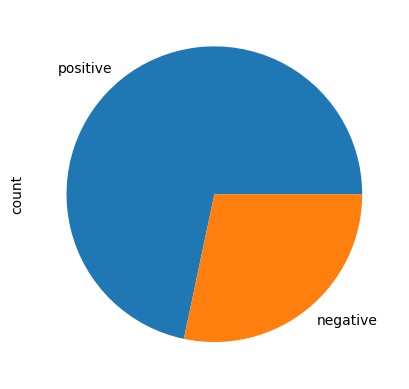

In [27]:
df['compound_label'].value_counts().plot(kind='pie')

In [28]:
df1 = pd.read_csv('/Users/krishnapeddibhotla/Downloads/US Election using twitter sentiment/Trumpall2.csv')

In [29]:
df1.head(5)

,user,text
0,manny_rosen,@sanofi please tell us how many shares the Cr...
1,osi_abdul,"https://t.co/atM98CpqF7 Like, comment, RT #P..."
2,Patsyrw,Your AG Barr is as useless &amp; corrupt as y...
3,seyedebrahimi_m,Mr. Trump! Wake Up! Most of the comments bel...
4,James09254677,After 4 years you think you would have figure...


In [30]:
print(df1['text'][2])
Tweet = TextBlob(df['text'][4])
Tweet.sentiment

 Your AG Barr is as useless &amp; corrupt as you are     Rep. Pramila Jayapal #SheGotItRight


Sentiment(polarity=0.0, subjectivity=0.0)

In [31]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
cleantweets = []
postags = []
import string
table = str.maketrans('','', string.punctuation)
for title in df1['text']:
    try:
        title = p.clean(text)
        #tokenize + lower case
        words2 = word_tokenize(text.lower())
        #remove puncts
        words3 = [w.translate(table) for w in words2]
        #remove stopwords
        words4 = [word for word in words3 if word not in stop_words]
        #applying lemmatization
        words5 = [lemmatizer.lemmatize(word) for word in words4]
                
        #combining all words
        cleantweets.append((" ".join(words5)).strip())
    except:
        cleantweets.append(title)
        continue

print(len(cleantweets))
df1['clean_Tweets'] = cleantweets

2788


In [32]:
pos=neg=obj=count=0

postagging = []

for title in df1['clean_Tweets']:
    list = word_tokenize(title)
    postagging.append(nltk.pos_tag(list))

df1['pos_tags'] = postagging

In [33]:
# Convert between the PennTreebank tags to simple Wordnet tags
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

In [34]:
def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    #Lemmatization
    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    #Synset is a special kind of a simple interface that is present in NLTK to look up words in WordNet. 
    #Synset instances are the groupings of synonymous words that express the same concept. 
    #Some of the words have only one Synset and some have several.
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

In [35]:
pos=neg=obj=count=0
senti_score = []

for pos_val in df1['pos_tags']:
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    for score in senti_val:
        try:
            pos = pos + score[1]  #positive score is stored at 2nd position
            neg = neg + score[2]  #negative score is stored at 3rd position
        except:
            continue
    senti_score.append(pos - neg)
    pos=neg=0    
    
df1['senti_score'] = senti_score

In [36]:
df1['compound_label'] = df1['senti_score'].apply(lambda number: 'positive' if number>=0 else 'negative')

In [37]:
df1.head(5)

,user,text,clean_Tweets,pos_tags,senti_score,compound_label
0,manny_rosen,@sanofi please tell us how many shares the Cr...,@sanofi please tell us how many shares the Cr...,"[(@, JJ), (sanofi, JJ), (please, NN), (tell, V...",-0.125,negative
1,osi_abdul,"https://t.co/atM98CpqF7 Like, comment, RT #P...","https://t.co/atM98CpqF7 Like, comment, RT #P...","[(https, NN), (:, :), (//t.co/atM98CpqF7, NN),...",0.000,positive
2,Patsyrw,Your AG Barr is as useless &amp; corrupt as y...,Your AG Barr is as useless &amp; corrupt as y...,"[(Your, PRP$), (AG, NNP), (Barr, NNP), (is, VB...",-0.500,negative
3,seyedebrahimi_m,Mr. Trump! Wake Up! Most of the comments bel...,Mr. Trump! Wake Up! Most of the comments bel...,"[(Mr., NNP), (Trump, NNP), (!, .), (Wake, VB),...",0.000,positive
4,James09254677,After 4 years you think you would have figure...,After 4 years you think you would have figure...,"[(After, IN), (4, CD), (years, NNS), (you, PRP...",-0.625,negative


<Axes: ylabel='count'>

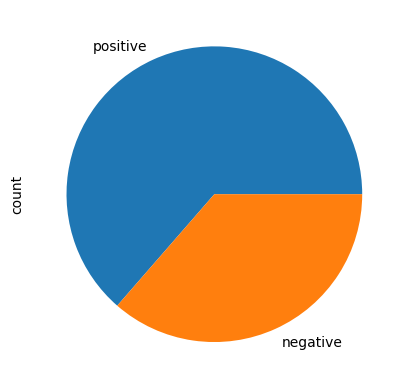

In [38]:
#Trump
df1['compound_label'].value_counts().plot(kind='pie')

<Axes: ylabel='count'>

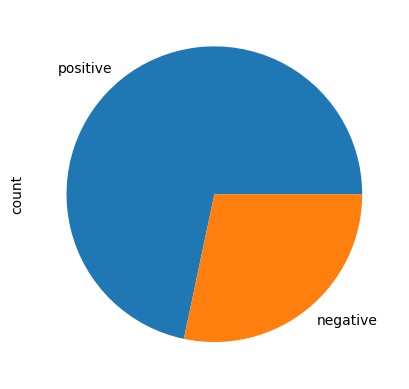

In [39]:
#Biden
df['compound_label'].value_counts().plot(kind='pie')